In [103]:
from transformers import AutoTokenizer
import spacy
import re
from bokeh.models import HoverTool, ColumnDataSource, CategoricalColorMapper, ContinuousColorMapper, LinearColorMapper, ColorBar, LabelSet, Label
from bokeh.plotting import figure, show, output_notebook
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.cluster import AgglomerativeClustering
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from gensim.models import KeyedVectors
from yellowbrick.cluster import KElbowVisualizer
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler, normalize
import requests
import pandas as pd
from gensim.test.utils import common_texts
import gensim.downloader
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from matplotlib import pyplot as plt
from bokeh.palettes import Spectral10
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import string
import sys
from nltk.tokenize import word_tokenize, sent_tokenize
import ipywidgets as widgets
import umap
from sklearn.feature_extraction.text import CountVectorizer

- gegeven de distributie van woorden, wat als je alle worden weg filter welke in het middelpunt van de curve vallen (66%)

gegeven een lijst met keywords, hoe kunnen we topics uit de documenten halen welke van toepassing zijn op de keywords?

# Research question 2

> *"Welke KPI's zitten verweven in de aangeleverde overheid documenten (denk aan geplande aantal huizen bijvoorbeeld), en wat zijn de overeenkomsten tussen deze KPI's? "*

In [104]:
import spacy
import warnings
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import wordpunct_tokenize
from tqdm import tqdm
from difflib import SequenceMatcher

lemmatizer = WordNetLemmatizer()
spacy_model = spacy.load("nl_core_news_lg")

def preprocess_phrase(phrase):
    split_phrase = wordpunct_tokenize(phrase.lower())
    return " ".join([ lemmatizer.lemmatize(i) for i in split_phrase ])

def semantic_similarity(X, Y, max_out=None):
    # This function loads the large English language model in spaCy
    # and uses it to calculate semantic similarity between each phrase in Y and the input phrase X.
    # Note that this function assumes that the phrases in Y are in English, 
    # and it may not work as well for other languages or for very short or ungrammatical phrases.
    
    # Create a Doc object for X
    doc1 = spacy_model(preprocess_phrase(X))

    # Calculate semantic similarity for each phrase in Y
    similarities = []
    for phrase in Y:
        doc2 = spacy_model(preprocess_phrase(phrase))
        similarity = doc1.similarity(doc2)
        similarities.append((doc2, similarity))
        
    # return similarities
    if not max_out:
        max_out = len(similarities)
    return sorted(similarities, key=lambda a: a[1], reverse=True)[0:max_out]

def syntactic_similarity(X, Y, max_out=None):
    # This function takes in two parameters: 
    # X, the single phrase to compare against the list of phrases
    # Y, the list of phrases to compare against. 
    # It returns a tuple containing the most similar phrase from Y and the corresponding syntactic similarity score.
    match_ratios = []
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for phrase in Y:
            matcher = SequenceMatcher(None, preprocess_phrase(X), preprocess_phrase(phrase))
            ratio = matcher.ratio()
            match_ratios.append((phrase, ratio))
    
    if not max_out:
        max_out = len(match_ratios)
        
    return sorted(match_ratios, key=lambda a: a[1], reverse=True)[0:max_out]

In [105]:
handmatige_kpi_collectie = pd.read_csv("handmatige_kpi_collectie.csv")
handmatige_kpi_collectie.head(3)

,KPI,Document,Bladzijde
0,In het centrum bouwen we ruim 10.000 woningen ...,Omgevingsvisie Breda 2040 Sterk en Veerkrachti...,9
1,We verbeteren de verbindingen voor voetgangers...,Omgevingsvisie Breda 2040 Sterk en Veerkrachti...,9
2,De noordelijke rondweg ondertunnelen we groten...,Omgevingsvisie Breda 2040 Sterk en Veerkrachti...,9


In [106]:
handmatige_kpi_collectie.shape

(90, 3)

## KPI similaritie measarumnets

In [107]:
# kpis = list(handmatige_kpi_collectie.KPI.astype(str))
# synt_syms = dict()
# for kpi in tqdm(kpis):
#     others = [ i for i in kpis if i != kpi ]
#     synt_syms[kpi] = syntactic_similarity(kpi, others, 5)
    
# with open("./synt_sema.txt", "w", encoding="utf-8") as file:
#     content = "<===> KPI + 5 meest overheenkomende KPI's (syntactisch) <===>\n\n"
#     for i in synt_syms:
#         content += i + "\n"
#         for sym in synt_syms[i]:
#             content += f"- {round(sym[1], 2)}\t{sym[0]}\n"
#         content += "\n"
        
#     file.write(content)

In [108]:
# sema_syms = dict()
# for kpi in tqdm(kpis):
#     others = [ i for i in kpis if i != kpi ]
#     sema_syms[kpi] = semantic_similarity(kpi, others, 5)
    
# with open("./sema_syms.txt", "w", encoding="utf-8") as file:
#     content = "<===> KPI + 5 meest overheenkomende KPI's (semantisch) <===>\n\n"
#     for i in sema_syms:
#         content += i + "\n"
#         for sym in sema_syms[i]:
#             content += f"- {round(sym[1], 2)}\t{sym[0]}\n"
#         content += "\n"
        
#     file.write(content)

In [109]:
# rows = []
# html_out = widgets.HBox()

# for i in zip(synt_syms, sema_syms):
#     synt = i[0]
#     sema = i[0]
    
#     grid_layout = widgets.Layout(
#         grid_auto_columns="min-content"
#     )
#     container_layout = widgets.Layout(
#         width='auto',
#         border="2px solid red",
#         flex_flow='col auto'
#     )
    
#     synt_syms_title = widgets.HTML(f"<h3>{synt}</h3>")
#     synt_syms_score = widgets.VBox([widgets.Label("Score:")] + [widgets.Label(str(round(i[1], 2)), layout=label_layout) for i in synt_syms[synt]])
#     synt_syms_phrase = widgets.VBox([widgets.Label("KPI:")] + [widgets.Label(str(i[0]), layout=label_layout) for i in synt_syms[synt]])
#     synt_syms_container = widgets.VBox([
#         synt_syms_title,
#         widgets.HBox([synt_syms_score, synt_syms_phrase], layout=grid_layout)
#     ], layout=container_layout)
        
#     sema_syms_title = widgets.HTML(f"<h3>{sema}</h3>")
#     sema_syms_score = widgets.VBox([widgets.Label("Score:")] + [widgets.Label(str(round(i[1], 2))) for i in sema_syms[sema]])
#     sema_syms_phrase = widgets.VBox([widgets.Label("KPI:")] + [widgets.Label(str(i[0])) for i in sema_syms[sema]])
#     sema_syms_container = widgets.VBox([
#         sema_syms_title,
#         widgets.HBox([sema_syms_score, sema_syms_phrase], layout=grid_layout)
#     ], layout=container_layout)
    
        
#     html_out.children += (widgets.HBox([synt_syms_container, sema_syms_container]), )
#     break

# html_out

We hebben nu een lijst met 90 KPI's. Het idee is om ruis KPI's te verwijderen. Wanneer dit gedaan is maken we een functie die alle symantisch/syntactisch overheen komende zinnen uit overheids documenten extrapoleerd welke 90% of meer overheen komen.

### Ruis KPI bepaling
**Wat maakt een goede KPI om in deze functies te gebruiken?**

Een KPI moet het volgende bevatten:
- ...

Gegeven een KPI, welke chunck komt daar het meest mee overheen

---

In [110]:
import io
import requests
import PyPDF2

def split_pdf_pages(pdf_data):
    pages = []
    reader = PyPDF2.PdfFileReader(io.BytesIO(pdf_data))

    for page_number in range(reader.getNumPages()):
        pages.append(reader.getPage(page_number))

    return pages

In [111]:
urls = ["https://file.notion.so/f/s/49da8fb5-000b-47bf-9788-1dcbdfdf80f6/Omgevingsvisie_Breda_2040_Sterk_en_Veerkrachtig_-_01-07-2021.pdf?id=3be70ed6-2a1a-460a-b326-f0031a4c4d81&table=block&spaceId=ca274338-dfb2-4f65-823d-2acde6195fea&expirationTimestamp=1684312025948&signature=7j13LI3pQfJCwASUOlCiPF8JzLPy6zZmMUcQjkV3xIA&downloadName=Omgevingsvisie+Breda+2040+Sterk+en+Veerkrachtig+-+01-07-2021.pdf"]

In [112]:
# kpis = list(handmatige_kpi_collectie.KPI.astype(str))

# page_content = []
# with open("./Definitief concept Omgevingsvisie Weert (20-08-2021).pdf", "rb") as file:
#     pdf_reader = PyPDF2.PdfFileReader(file)
#     pages = []
#     for page_number in tqdm(range(pdf_reader.getNumPages())):
#         page = pdf_reader.getPage(page_number)
#         page_content.append(page.extract_text())

In [113]:
# phrases = re.split("\.|\n", "\n".join(page_content))
# chuncks = []
# N_chunks = 3
# while len(phrases) >= N_chunks:
#     chunk = " ".join(phrases[0:N_chunks])
#     chuncks.append(chunk)
#     phrases = phrases[1:]

In [114]:
# chunk_synt_syms = dict()
# for kpi in tqdm(kpis):
#     chunk_synt_syms[kpi] = syntactic_similarity(kpi, chuncks, 5)

In [115]:
# for i in chunk_synt_syms:
#     print(i)
#     for sim_chunck in chunk_synt_syms[i]:
#         print(sim_chunck)
#     print("----------------------------")

In [116]:
# chunk_sema_syms = dict()
# for kpi in tqdm(kpis):
#     chunk_sema_syms[kpi] = semantic_similarity(kpi, chuncks, 5)

In [117]:
# for i in chunk_sema_syms:
#     print(i)
#     for sim_chunck in chunk_sema_syms[i]:
#         print(sim_chunck)
#     print("----------------------------")

Na aanleiding van bovenstaande uitkomsten kunnen wij concluderen dat het gebruik van semantische overheenkomst meting beter werkt dan syntactische metingen.

Er moet wel gekeken worden naar:
- andere manier van chunck verwerking (groter maken, minder overlapping etc)
- kwalitiet van sommige KPI's is soms twijfelbaar, er moet nader gekeken worden welke handmatig gekozen KPI's nouw echt het beste resultaat geven

---

## Pipeline testing

In [118]:
from tqdm import tqdm
import PyPDF2

# get file content
page_content = []
with open("./Definitief concept Omgevingsvisie Weert (20-08-2021).pdf", "rb") as file:
    pdf_reader = PyPDF2.PdfReader(file)
    pages = []
    print("Getting page content")
    for page_number in tqdm(range(len(pdf_reader.pages))):
        page = pdf_reader.pages[page_number]
        page_content.append(page.extract_text())
        
# read KPI collection
kpis = list(pd.read_csv("handmatige_kpi_collectie.csv").KPI.astype(str))

Getting page content


100%|██████████| 41/41 [00:01<00:00, 40.72it/s]


To expend the list of KPI's, we measure the most syntactical similair chuncks of text from a given document. Because we don't know up front how many sentences the KPI extends to, we need to take chuncks of text from the document. These chuncks will be groups of N sentences. We have to allow for overlapping chuncks so that we are sure to measure entire KPI's. Then we measure the similairity between the handpicked KPI's and the given chuncks.

In [119]:
import json

In [120]:
# globals, might need to be tweaked for better results
N_chunks = 5
kpi_sema_treshhold = 0.8

In [121]:
joined_content = "\n\n".join(page_content) #re.sub("[\.\n]+", " ", )
phrases = [ p for p in re.split("[\?\!\.\n]+", joined_content) if p ]
chuncks = []

while len(phrases) >= N_chunks:
    chunk = " ".join(phrases[0:N_chunks])
    chuncks.append(chunk)
    phrases = phrases[1:]

```python
# store the chuncks which are sementicly similair to a given KPI
chunk_sema_syms = dict()

for kpi in tqdm(kpis):
    sema_chuncks = semantic_similarity(kpi, chuncks)
    
    # only store if the chunk and the KPI are 90% similair or more
    kpi_sema_treshhold = 0.8
    chunk_sema_syms[kpi] = [ i for i in sema_chuncks if i[1] >= kpi_sema_treshhold ]
    
parsed_chuncks = [ str(j[0]) for i in list(chunk_sema_syms.values()) for j in i if i ]
json_object = json.dumps(parsed_chuncks, indent=4)

with open("parsed_chuncks.json", "w") as file:
    file.write(json_object)
```

```stdout
100%|██████████████████████████████████████████████████████████████████████████████████| 90/90 [18:28<00:00, 12.32s/it]
```

In [122]:
parsed_chuncks = None

with open("parsed_chuncks.json", "r") as file:
    parsed_chuncks = json.load(file)

In [123]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import Pipeline


vec = TfidfVectorizer(tokenizer=word_tokenize)
# vec = CountVectorizer(tokenizer=word_tokenize)
lda = LatentDirichletAllocation(n_components=10, random_state=0)

pipe = Pipeline([
    ("vec", vec),
    ("model", lda)
])

topic_matrix = pipe.fit_transform(parsed_chuncks)

c:\Users\Antwa\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [124]:
lda_df = pd.DataFrame(topic_matrix, columns = pipe.get_feature_names_out())
lda_df.shape

(55135, 10)

In [125]:
lda_df

,latentdirichletallocation0,latentdirichletallocation1,latentdirichletallocation2,latentdirichletallocation3,latentdirichletallocation4,latentdirichletallocation5,latentdirichletallocation6,latentdirichletallocation7,latentdirichletallocation8,latentdirichletallocation9
0,0.014321,0.014321,0.014320,0.014321,0.014321,0.871114,0.014321,0.014320,0.014321,0.014321
1,0.015632,0.015631,0.015631,0.015631,0.015631,0.859319,0.015631,0.015631,0.015631,0.015632
2,0.016424,0.016423,0.016423,0.852188,0.016423,0.016425,0.016424,0.016423,0.016424,0.016423
3,0.016383,0.016382,0.016382,0.852557,0.016382,0.016384,0.016383,0.016382,0.016383,0.016382
4,0.016790,0.016789,0.016789,0.848897,0.016789,0.016790,0.016790,0.016789,0.016790,0.016789
...,...,...,...,...,...,...,...,...,...,...
55130,0.019620,0.019620,0.019622,0.823422,0.019618,0.019621,0.019620,0.019619,0.019620,0.019619
55131,0.860274,0.015527,0.015526,0.015525,0.015523,0.015523,0.015526,0.015525,0.015528,0.015524
55132,0.017518,0.017519,0.017519,0.017521,0.017517,0.017518,0.017517,0.842331,0.017520,0.017520
55133,0.017403,0.017402,0.017402,0.017402,0.017401,0.843381,0.017401,0.017402,0.017402,0.017403


In [126]:
lda_df


,latentdirichletallocation0,latentdirichletallocation1,latentdirichletallocation2,latentdirichletallocation3,latentdirichletallocation4,latentdirichletallocation5,latentdirichletallocation6,latentdirichletallocation7,latentdirichletallocation8,latentdirichletallocation9
0,0.014321,0.014321,0.014320,0.014321,0.014321,0.871114,0.014321,0.014320,0.014321,0.014321
1,0.015632,0.015631,0.015631,0.015631,0.015631,0.859319,0.015631,0.015631,0.015631,0.015632
2,0.016424,0.016423,0.016423,0.852188,0.016423,0.016425,0.016424,0.016423,0.016424,0.016423
3,0.016383,0.016382,0.016382,0.852557,0.016382,0.016384,0.016383,0.016382,0.016383,0.016382
4,0.016790,0.016789,0.016789,0.848897,0.016789,0.016790,0.016790,0.016789,0.016790,0.016789
...,...,...,...,...,...,...,...,...,...,...
55130,0.019620,0.019620,0.019622,0.823422,0.019618,0.019621,0.019620,0.019619,0.019620,0.019619
55131,0.860274,0.015527,0.015526,0.015525,0.015523,0.015523,0.015526,0.015525,0.015528,0.015524
55132,0.017518,0.017519,0.017519,0.017521,0.017517,0.017518,0.017517,0.842331,0.017520,0.017520
55133,0.017403,0.017402,0.017402,0.017402,0.017401,0.843381,0.017401,0.017402,0.017402,0.017403


Het is onhandig om ongepaste data door de volledige pipeline te sturen, speciaal voor de laatste stap waarin wordclouds worden gemaakt. Dit komt doordat de functie om wordclouds te maken meerdere variabelen verwacht, en een uitdaging vormt bij het integreren ervan in een pipeline. In een typische pipeline-architectuur is het wenselijk dat functies een enkele invoer nemen en een enkele uitvoer retourneren, om een consistente gegevensstroom te behouden. Het kan problematisch zijn als andere stappen in de pipeline niet dezelfde invoerstructuur hebben of niet alle benodigde gegevens kunnen leveren.

Vanwege dit probleem hebben we ervoor gekozen om deze methode buiten de pipeline te houden.

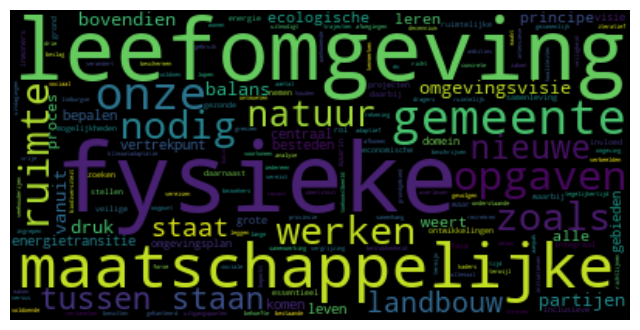

<Figure size 1000x1000 with 0 Axes>

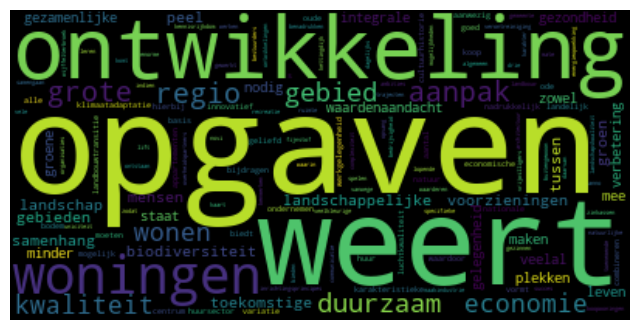

<Figure size 1000x1000 with 0 Axes>

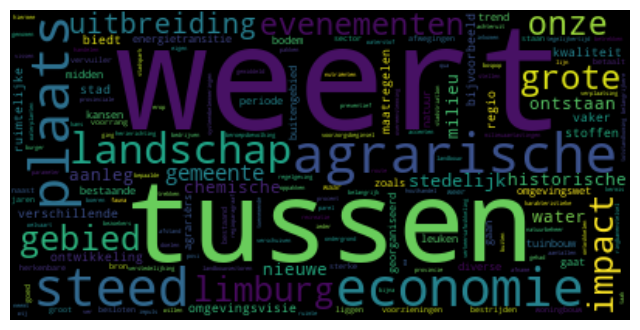

<Figure size 1000x1000 with 0 Axes>

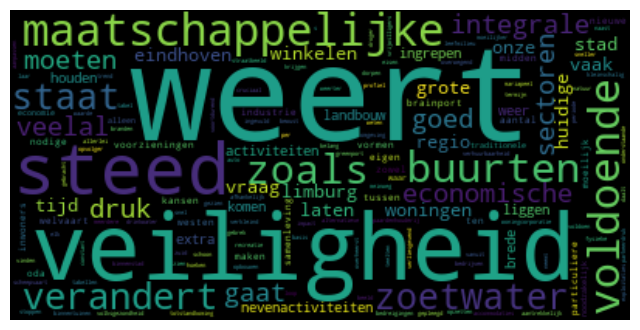

<Figure size 1000x1000 with 0 Axes>

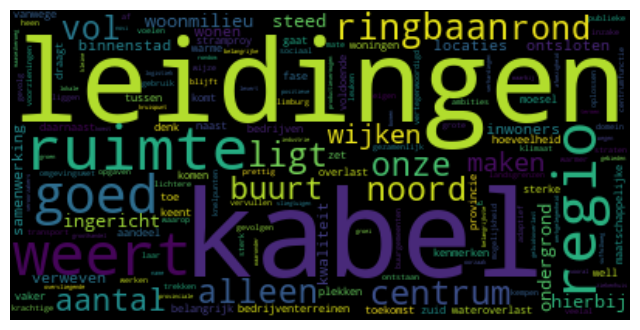

<Figure size 1000x1000 with 0 Axes>

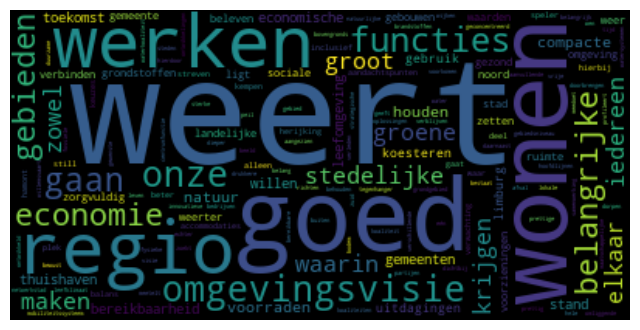

<Figure size 1000x1000 with 0 Axes>

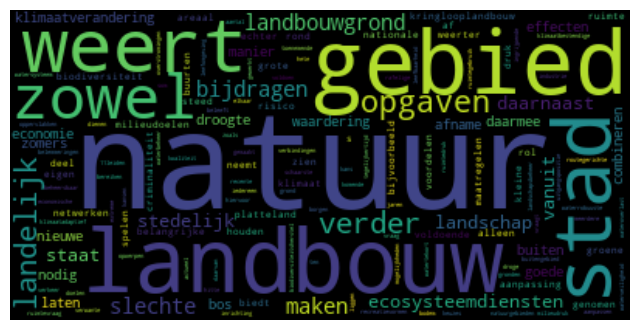

<Figure size 1000x1000 with 0 Axes>

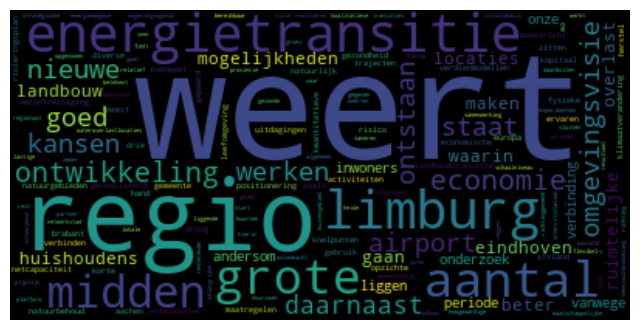

<Figure size 1000x1000 with 0 Axes>

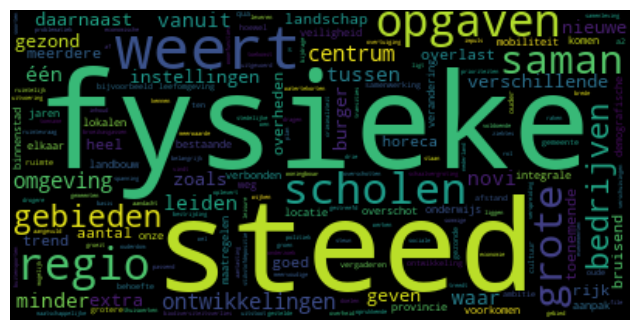

<Figure size 1000x1000 with 0 Axes>

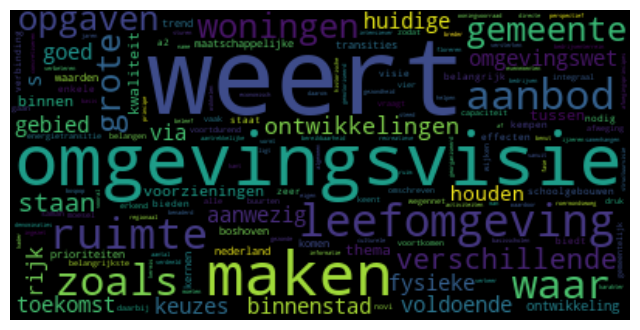

<Figure size 1000x1000 with 0 Axes>

In [127]:
from wordcloud import WordCloud
from collections import Counter

def generate_wordclouds(df, parsed_chuncks, stopwords_set=None, figsize=None):
    df['highest_topic'] = df.idxmax(axis=1).values
    
    for i in range(df.columns.__len__() - 1):
        tokens = []
        topicNr = i
        topic = df[df['highest_topic'] == "latentdirichletallocation" + str(topicNr)].index
        for j in topic:
            tokens.extend(wordpunct_tokenize(parsed_chuncks[j]))
        
        if stopwords_set is None:
            stopwords_set = set(stopwords.words('dutch'))
        
        tokens = [t for t in tokens if t not in stopwords_set]

        wordcloud = WordCloud(collocations=False).generate(" ".join(tokens))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")

        if figsize is not None:
            plt.figure(figsize=figsize)
        else:
            plt.rcParams["figure.figsize"] = (4, 3)

        plt.show()

        
generate_wordclouds(lda_df, parsed_chuncks, figsize=(10, 10))

## Evaluation

Testen of een andere methode van scoring (als LDA TFIDF gebruikt testen wij count en TFIDF) om te kijken of dit tot ruis/valse conclusies kan lijden

What is topic coherence? Topic Coherence measures score a single topic by measuring the degree of semantic similarity between high scoring words in the topic. These measurements help distinguish between topics that are semantically interpretable topics and topics that are artifacts of statistical inference.